## Import Library and Packages

In [ ]:
pip install pycocotools

In [ ]:
!pip install roboflow

In [ ]:
!git init
!git clone https://github.com/pytorch/vision.git
!cd vision
!cp ./vision/references/detection/utils.py ./
!cp ./vision/references/detection/transforms.py ./
!cp ./vision/references/detection/engine.py ./
!cp ./vision/references/detection/coco_eval.py ./
!cp ./vision/references/detection/coco_utils.py ./

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
Cloning into 'vision'...
remote: Enumerating objects: 496746, done.
remote: Counting objects: 100% (10356/10356), done.
remote: Compressing objects: 100% (563/563), done.
remote: Total 496746 (delta 9788), reused 10320 (delta 9775), pack-reused 486390
Receiving objects: 100% (496746/496746), 961.96 MiB | 20.14 MiB/s, done.
Resolving deltas: 100% (463023/463023), done.


In [ ]:
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
import os
import torch
import torchvision
from torchvision import transforms
from torchvision import transforms as T2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import tv_tensors
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models import ResNet50_Weights
import matplotlib.pyplot as plt
import time
import math
import utils

<h1>Load and Preprocess Dataset<h1>

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="npimG02qeIdyJ85f34Dj")
project = rf.workspace("plat-kendaraan").project("vehicle-and-license-plate")
version = project.version(3)
dataset = version.download("tensorflow")

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
Image_path = "vehicle-and-license-plate-3"

train = pd.read_csv("vehicle-and-license-plate-3/train/_annotations.csv")
valid = pd.read_csv("vehicle-and-license-plate-3/valid/_annotations.csv")
test = pd.read_csv("vehicle-and-license-plate-3/test/_annotations.csv")

In [ ]:
test.drop(["width","height"],axis=1,inplace=True)
test.drop(test[test['class'] != 'License_Plate'].index, inplace=True)

In [ ]:
train.drop(["width","height"],axis=1,inplace=True)
train.drop(train[train['class'] != 'License_Plate'].index, inplace=True)

In [ ]:
valid.drop(["width","height"],axis=1,inplace=True)
valid.drop(valid[valid['class'] != 'License_Plate'].index, inplace=True)

In [ ]:
class customizeData(torch.utils.data.Dataset):
    def __init__(self,df,mode):
        self.df=df
        self.mode=mode
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        img_name = self.df.iloc[idx]['filename']
        boxes = self.df[self.df.filename == img_name].values[:,2:].astype("float")
        img = Image.open("/content/"+self.mode+"/" + img_name).convert('RGB')
        labels = torch.ones((boxes.shape[0]),dtype=torch.int64)
        target = {}
        target["image_id"] = idx
        target["boxes"] = torch.tensor(boxes)
        target["labels"] = labels
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        target["iscrowd"] = torch.zeros((boxes.shape[0]), dtype=torch.int64)

        img=T2.ToTensor()(img)
        return img, target


In [ ]:
def custom_collate(data):
    return data

In [ ]:
mode="train"
train_dl = torch.utils.data.DataLoader(customizeData(train,mode),
                                     batch_size=2,
                                     shuffle=True,
                                     collate_fn = custom_collate,
                                     pin_memory=True if torch.cuda.is_available() else False)


In [ ]:
mode="valid"
val_dl = torch.utils.data.DataLoader(customizeData(valid,mode),
                                     batch_size=1,
                                     shuffle=False,
                                     collate_fn = custom_collate,
                                     pin_memory=True if torch.cuda.is_available() else False)

In [ ]:
mode="test"
test_dl = torch.utils.data.DataLoader(customizeData(test,mode),
                                     shuffle=False,
                                     collate_fn = custom_collate,
                                     pin_memory=True if torch.cuda.is_available() else False)

<h1>Load Pretrained Faster RCNN model<h1>

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
num_classes=2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 68.5MB/s]


<h1>Fine-tuning Model<h1>

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9,weight_decay=0.0005)
num_epochs = 20
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for data in metric_logger.log_every(data_loader, print_freq, header):
        images=[]
        targets=[]
        for d in data:
            images.append(d[0].to(device))
            targ = {}
            targ["boxes"] = d[1]["boxes"].to(device)
            targ["labels"] = d[1]["labels"].to(device)
            targets.append(targ)
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

#################################################<br>
The following evaluation metric is adapted from https://github.com/pytorch/vision/blob/main/references/detection/engine.py
##################################################

In [ ]:
from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset
def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    print(iou_types)
    return iou_types


@torch.inference_mode()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = "Test:"

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for data in metric_logger.log_every(data_loader, 100, header):
        images=[]
        targets=[]
        for d in data:
            images.append(d[0].to(device))
            targ = {}
            targ["boxes"] = d[1]["boxes"]
            targ["labels"] = d[1]["labels"]
            targ["image_id"] = d[1]["image_id"]
            targ["iscrowd"] = d[1]["iscrowd"]
            targ["area"] = d[1]["area"]
            targets.append(targ)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time
        res = {target["image_id"]: output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

<h1>Training and Saving Model based on highest mAP score

In [ ]:
model.to(device)
best_mAP = 0.0
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=1000)
    lr_scheduler.step()
    coco_evaluator=evaluate(model, val_dl, device=device)

    mAP = coco_evaluator.coco_eval['bbox'].stats[0]

    # Save the model with the highest mAP score
    if mAP > best_mAP:
        best_mAP = mAP
        torch.save(model.state_dict(), "/content/carobjdetec.pt")

Epoch: [0]  [   0/2681]  eta: 2:28:45  lr: 0.000020  loss: 0.6580 (0.6580)  loss_classifier: 0.4976 (0.4976)  loss_box_reg: 0.0215 (0.0215)  loss_objectness: 0.1307 (0.1307)  loss_rpn_box_reg: 0.0083 (0.0083)  time: 3.3292  data: 0.0399  max mem: 1643
Epoch: [0]  [1000/2681]  eta: 0:11:03  lr: 0.010000  loss: 0.0704 (0.1152)  loss_classifier: 0.0190 (0.0388)  loss_box_reg: 0.0492 (0.0683)  loss_objectness: 0.0011 (0.0060)  loss_rpn_box_reg: 0.0010 (0.0020)  time: 0.3941  data: 0.0129  max mem: 1802
Epoch: [0]  [2000/2681]  eta: 0:04:28  lr: 0.010000  loss: 0.0556 (0.0933)  loss_classifier: 0.0156 (0.0305)  loss_box_reg: 0.0358 (0.0576)  loss_objectness: 0.0003 (0.0035)  loss_rpn_box_reg: 0.0007 (0.0017)  time: 0.3937  data: 0.0125  max mem: 1802
Epoch: [0]  [2680/2681]  eta: 0:00:00  lr: 0.010000  loss: 0.0519 (0.0847)  loss_classifier: 0.0157 (0.0271)  loss_box_reg: 0.0376 (0.0533)  loss_objectness: 0.0002 (0.0027)  loss_rpn_box_reg: 0.0010 (0.0016)  time: 0.3843  data: 0.0117  max me

<h1>Accuracy Result on Test Dataset<h1>

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/carobjdetec.pt",map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
evaluate(model, test_dl, device=device)

creating index...
index created!
['bbox']
Test:  [ 0/23]  eta: 0:00:02  model_time: 0.1180 (0.1180)  evaluator_time: 0.0008 (0.0008)  time: 0.1265  data: 0.0071  max mem: 1802
Test:  [22/23]  eta: 0:00:00  model_time: 0.0783 (0.0815)  evaluator_time: 0.0008 (0.0008)  time: 0.0866  data: 0.0073  max mem: 1802
Test: Total time: 0:00:02 (0.0903 s / it)
Averaged stats: model_time: 0.0783 (0.0815)  evaluator_time: 0.0008 (0.0008)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.859
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.855
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.880
 Average Recall     (A

In [ ]:
#model with different settings, optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9,weight_decay=0.0005), num_epoch=10
model.load_state_dict(torch.load("/content/drive/MyDrive/carobjdetec2.pt",map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
evaluate(model, test_dl, device=device)

creating index...
index created!
['bbox']
Test:  [ 0/23]  eta: 0:02:13  model_time: 5.8109 (5.8109)  evaluator_time: 0.0035 (0.0035)  time: 5.8237  data: 0.0092
Test:  [22/23]  eta: 0:00:06  model_time: 6.5029 (6.9085)  evaluator_time: 0.0013 (0.0017)  time: 6.9375  data: 0.0104
Test: Total time: 0:02:39 (6.9210 s / it)
Averaged stats: model_time: 6.5029 (6.9085)  evaluator_time: 0.0013 (0.0017)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.803
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.813
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.784
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   

In [ ]:
def show_sample_from_image(model, img):
    img = transforms.ToTensor()(img)
    # get output from model
    model.eval()
    with torch.no_grad():
        output = model([img.to(device)])
    out_boxes = output[0]["boxes"]
    out_scores = output[0]["scores"]

    img = (img.permute(1,2,0).cpu().detach().numpy() * 255).astype('uint8')
    img = Image.fromarray(img)

    draw = ImageDraw.Draw(img)
    # predicted bb
    for box in out_boxes:
        draw.rectangle(list(box), fill=None, outline="red", width=2)

    return img,out_boxes

In [ ]:
img = Image.open("/content/drive/MyDrive/car image 3.jpg")
img, bb = show_sample_from_image(model, img)
display(img)

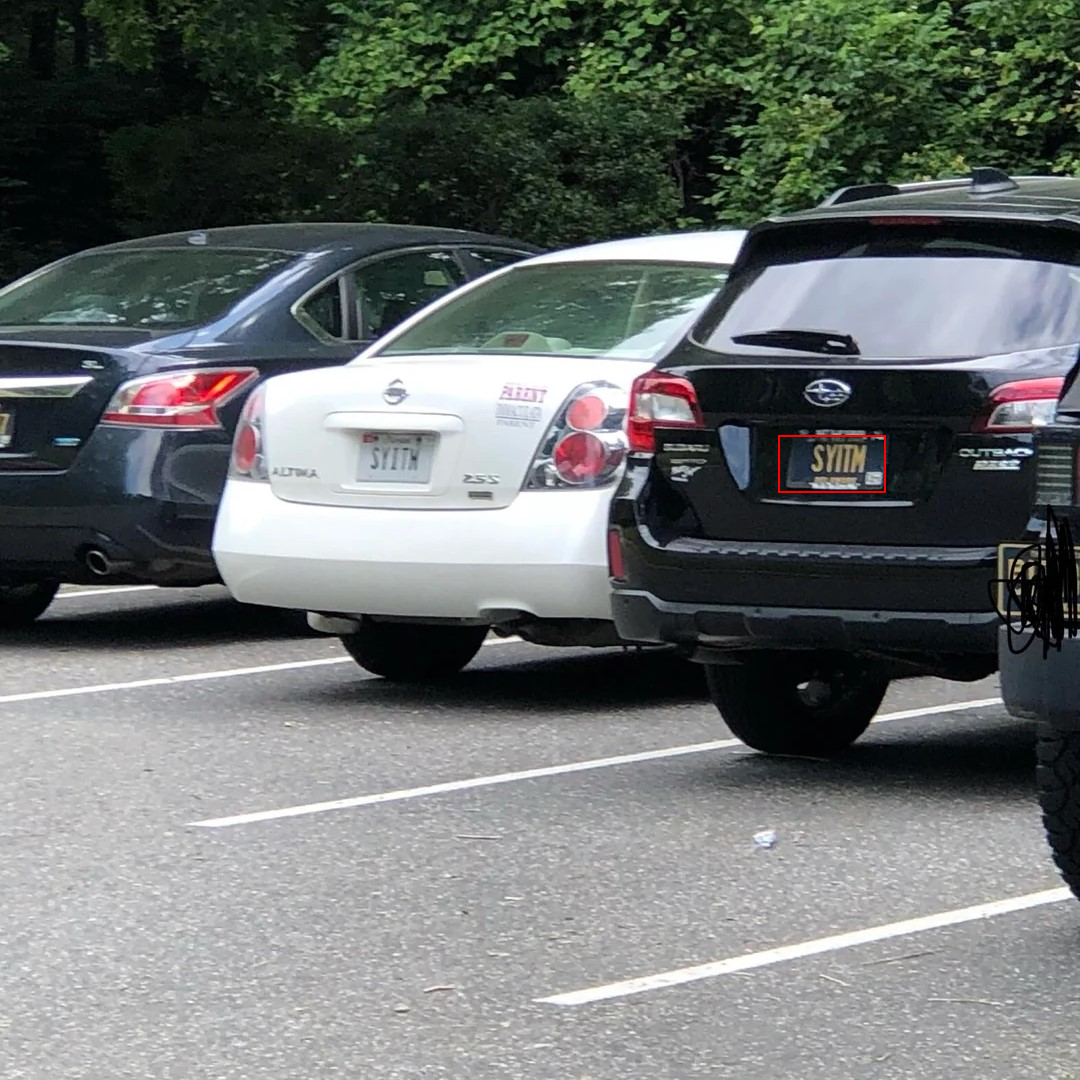